In [23]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from scipy.stats import linregress
import math
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from numpy import trapz
plt.style.use('seaborn-darkgrid')

# Download Data Part 1

In [28]:
col_names = ['time','sw_up','sw_down','lw_up','lw_down','body_temp_C','body_temp_K','tc_lw_up','tc_lw_down','net','sky_temp','g_temp']
cols=[0,2,3,4,5,6,7,8,9,10,11,12]
solar = pd.read_csv('deere_CR3000_CNR1.csv',header=3,names=col_names,usecols=cols,parse_dates=['time'])

start_date = pd.Timestamp(2020,3,13,11,42,0)
end_date = pd.Timestamp(2020,3,13,11,56,30)
mask1 = (solar['time'] > start_date) & (solar['time'] <= end_date)
solar_part1 = solar.loc[mask1]

start_date = pd.Timestamp(2020,3,13,12,0,0)
end_date = pd.Timestamp(2020,3,13,12,9,30)
mask2 = (solar['time'] > start_date) & (solar['time'] <= end_date)
solar_part2 = solar.loc[mask2]
solar.head()

,time,sw_up,sw_down,lw_up,lw_down,body_temp_C,body_temp_K,tc_lw_up,tc_lw_down,net,sky_temp,g_temp
0,2020-03-13 11:23:00,2.102,0.162,8.14,1.671,21.55,294.7,435.8,429.3,8.41,22.94,21.83
1,2020-03-13 11:23:10,2.102,0.129,8.12,1.639,21.56,294.7,435.8,429.3,8.45,22.95,21.84
2,2020-03-13 11:23:20,2.135,0.151,8.05,1.606,21.56,294.7,435.8,429.3,8.43,22.94,21.83
3,2020-03-13 11:23:30,2.124,0.140,8.10,1.639,21.56,294.7,435.8,429.4,8.44,22.95,21.84
4,2020-03-13 11:23:40,2.081,0.108,8.30,1.649,21.56,294.7,436.0,429.4,8.62,22.98,21.85


#### Plot downwelling and upwelling sw radiation

Text(0.5,1,'Shortwave Radiation')

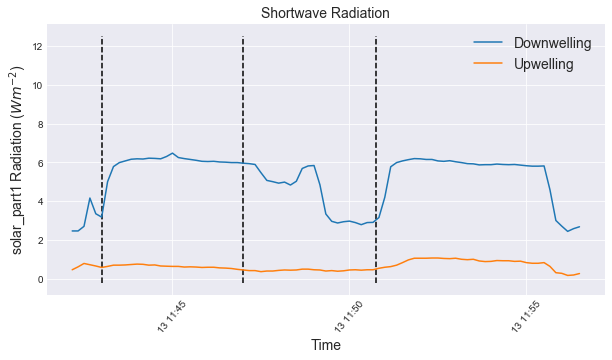

In [29]:
plt.figure(figsize=(10,5))
plt.plot(solar_part1['time'],solar_part1['sw_up'])
plt.plot(solar_part1['time'],solar_part1['sw_down'])

speed_times=[pd.Timestamp(2020,3,13,11,43,0),pd.Timestamp(2020,3,13,11,47,0),
             pd.Timestamp(2020,3,13,11,50,45)]

plt.vlines(speed_times,-0.2,12.5,linestyle = '--')
plt.legend(['Downwelling','Upwelling'],fontsize=14)
plt.xticks(rotation=50)
plt.grid(True)
plt.ylabel('solar_part1 Radiation ($W m^{-2}$)',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.title('Shortwave Radiation',fontsize=14)

Text(0.5,1,'Albedo over time')

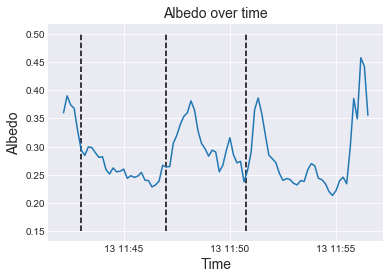

In [30]:
solar_part1['albedo']=solar_part1['lw_down']/solar_part1['lw_up']
plt.plot(solar_part1['time'],solar_part1['albedo'])
plt.vlines(speed_times,0.15,0.5,linestyle = '--')
plt.ylabel('Albedo',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.title('Albedo over time',fontsize=14)

In [31]:
start_date = pd.Timestamp(2020,3,13,11,43,0)
end_date = pd.Timestamp(2020,3,13,11,46,30)
mask1 = (solar_part1['time'] > start_date) & (solar_part1['time'] <= end_date)
bare_desk = solar_part1.loc[mask1]
print("BARE DESK ALBEDO = ",round(bare_desk['albedo'].mean(),2))

start_date = pd.Timestamp(2020,3,13,11,51,0)
end_date = pd.Timestamp(2020,3,13,11,54,0)
mask2 = (solar_part1['time'] > start_date) & (solar_part1['time'] <= end_date)
snow_ground = solar_part1.loc[mask2]
print("WHITE PAPER ALBEDO = ",round(snow_ground['albedo'].mean(),2))

BARE DESK ALBEDO =  0.26
WHITE PAPER ALBEDO =  0.28


# Download Data Part 2

In [32]:
col_names = ['time','body_temp_C','therm_temp','targ_temp']

"""
body_temp is surface body temperature of IR thermometer in deg C
voltage output of thermistor in mV
therm_temp is target temperature; calculatedby adding the sensor body temperature raised to the fourth power and 
the mV output multiplied by the slope (m) and the y-intercept(b),then the fourth root of this sum
"""

cols=[0,2,3,4]
infra = pd.read_csv('deere_CR3000_IRR-P.csv',header=3,names=col_names,usecols=cols,parse_dates=['time'])

start_date = pd.Timestamp(2020,3,13,12,0,0)
end_date = pd.Timestamp(2020,3,13,12,9,30)
mask1 = (infra['time'] > start_date) & (infra['time'] <= end_date)
infra = infra.loc[mask1]
infra.head()

,time,body_temp_C,therm_temp,targ_temp
214,2020-03-13 12:00:10,22.77,0.016,22.91
215,2020-03-13 12:00:20,22.78,0.025,23.08
216,2020-03-13 12:00:30,22.80,0.021,23.04
217,2020-03-13 12:00:40,22.83,0.020,23.04
218,2020-03-13 12:00:50,22.87,-0.019,22.40


In [51]:
sigma = 5.67*10**(-8)

def stefan_boltzman(lw):
    """
    returns temperature in deg C using the Stefan-Boltzman Law 
    """
    return ((lw/sigma)**(1/4))-273.15

In [52]:
solar_part2.head()

,time,sw_up,sw_down,lw_up,lw_down,body_temp_C,body_temp_K,tc_lw_up,tc_lw_down,net,sky_temp,g_temp
214,2020-03-13 12:00:10,2.382,0.237,6.921,3.590,22.03,295.2,437.4,434.1,5.476,23.21,22.65
215,2020-03-13 12:00:20,2.361,0.237,7.276,3.525,22.03,295.2,437.7,434.0,5.875,23.27,22.63
216,2020-03-13 12:00:30,2.361,0.269,7.341,3.557,22.03,295.2,437.8,434.0,5.875,23.28,22.64
217,2020-03-13 12:00:40,2.296,0.194,7.654,4.797,22.04,295.2,438.2,435.3,4.959,23.34,22.86
218,2020-03-13 12:00:50,2.296,0.205,7.481,4.064,22.04,295.2,438.0,434.6,5.509,23.31,22.73


#### Plot estimated ground temp from upwelling longwave
(assume ground is a blackbody)

In [56]:
solar_part2['ground_temp_calc']=stefan_boltzman(solar_part2['tc_lw_down'])

Text(0.5,1,'Albedo over time')

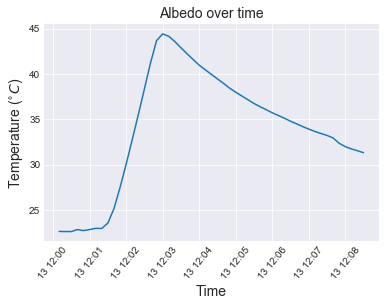

In [63]:
plt.plot(solar_part2['time'],solar_part2['ground_temp_calc'])
plt.ylabel('Temperature ($^{\circ} C$)',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.xticks(rotation=50)
plt.title('Albedo over time',fontsize=14)